<a href="https://www.kaggle.com/code/khoatran311/tuned-lgbm-model-for-predicting-productivity?scriptVersionId=298625081" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sea 
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline as pipe
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

import lightgbm, xgboost, catboost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import joblib
import optuna
import shap

import warnings
warnings.filterwarnings("ignore")

In [2]:
RMSE = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))

In [3]:
train = pd.read_csv("/kaggle/input/student-performance-prediction-machine-learning-challenge/train.csv")
test  = pd.read_csv("/kaggle/input/student-performance-prediction-machine-learning-challenge/test.csv")
sample_submission = pd.read_csv("/kaggle/input/student-performance-prediction-machine-learning-challenge/sample_submission.csv")

train.drop(columns=["id", "student_id"], inplace=True)
test.drop(columns=["id", "student_id"], inplace=True)

In [4]:
train.head()

,age,gender,study_hours_per_day,sleep_hours,phone_usage_hours,social_media_hours,youtube_hours,gaming_hours,breaks_per_day,coffee_intake_mg,exercise_minutes,assignments_completed,attendance_percentage,stress_level,focus_score,final_grade,productivity_score
0,28,Other,4.56,7.61,1.70,7.23,3.80,3.18,2,256,102,14,52.72,6,68,70.48,55.29
1,18,Female,7.95,8.17,4.24,5.50,4.80,3.53,9,370,115,17,87.51,1,69,57.67,78.68
2,19,Male,6.06,9.02,3.17,5.08,5.09,3.74,5,250,33,9,72.39,8,57,72.51,60.66
3,21,Female,1.40,8.06,2.35,1.03,0.13,5.23,4,55,110,0,87.47,5,34,81.93,37.51
4,25,Male,9.27,7.39,10.68,5.21,3.43,5.38,11,436,66,17,47.66,5,37,49.11,50.72


In [5]:
def prepare_categorical(X_train, X_val, cat_features):
    X_train = X_train.copy()
    X_val   = X_val.copy()
    for col in cat_features:
        X_train[col] = X_train[col].astype("category")
        X_val[col]   = X_val[col].astype("category")
    return X_train, X_val


def cross_validate(model, model_type, X, y, cat_features=["gender"], n_splits=5):
    kfold  = KFold(n_splits=n_splits, shuffle=True, random_state=3126)
    scores = np.zeros(n_splits) 

    for i,(train_idx,val_idx) in enumerate(kfold.split(X)):
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_val,   y_val   = X.iloc[val_idx,:],   y[val_idx]

        ## Converts categorical features to 'category' type
        X_train, X_val = prepare_categorical(X_train, X_val, cat_features)
        cloned_model = clone(model)

        ## Fits model
        if model_type=="lgbm":
            cloned_model.fit(
                X_train, y_train,
                categorical_feature=cat_features,
                eval_set=[(X_val, y_val)],
                callbacks=[lightgbm.early_stopping(100, verbose=False)])
            
        elif model_type=="xgboost":
            cloned_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=100, verbose=False)
            
        elif model_type=="catboost":
            pass
        else: 
            cloned_model.fit(X_train, y_train)

        ## Stores the RMSE score
        scores[i] = RMSE(y_val, cloned_model.predict(X_val))
    return scores

In [6]:
X = train.copy()
y = X.pop("productivity_score")

# Evaluating LGBM Regressor

In [7]:
# def objective(trial):
#     params = {
#         "objective": "regression",
#         "metric":"rmse",
#         "n_estimators":trial.suggest_int("n_estimators", 100, 5000, step=100),
#         "max_depth":trial.suggest_int("max_depth", 3, 10),
#         "min_child_samples":trial.suggest_int("min_child_samples", 15, 200),
#         "learning_rate":trial.suggest_float("learning_rate", .01, .5, log=True),
#         "subsample_freq":trial.suggest_int("subsample_freq", 0, 10),
#         "colsample_bytree":trial.suggest_float("colsample_bytree", 0.5, 0.9),
#         "reg_alpha":trial.suggest_float("reg_alpha", 0.001, 5.0, log=True),
#         "reg_lambda":trial.suggest_float("reg_lambda", 0.001, 5.0, log=True),
#     }
#     if params["subsample_freq"]>0:
#         params["subsample"] = trial.suggest_float("subsample", 0.75, 0.9)
#     params["num_leaves"] = trial.suggest_int("num_leaves", 4, min(2**params["max_depth"], 256))
    
#     params["random_state"] = 3126
#     params["n_jobs"]       = -1
#     params["verbosity"]    = -1
    
#     model  = LGBMRegressor(**params)
#     scores = cross_validate(model, "lgbm", X, y)
#     return np.mean(scores)


# study = optuna.create_study(
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(seed=3126),
#     pruner=optuna.pruners.MedianPruner(n_warmup_steps=15)
# )
# study.optimize(objective, n_trials=200)

In [8]:
# 5 fold mean RMSE of 0.313
lgbm_params = {
    "objective": "regression",
    "metric":"rmse",
    'n_estimators': 4200,
    'max_depth': 4, 
    'min_child_samples': 27, 
    'learning_rate': 0.4519543556274892, 
    'subsample_freq': 7, 
    'colsample_bytree': 0.6394789787333435, 
    'reg_alpha': 2.8227813683691134, 
    'reg_lambda': 3.609134307913427, 
    'subsample': 0.8830822978218495, 
    'num_leaves': 4,
    'random_state':3126,
    'n_jobs':-1,
    'verbosity':-1
}


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=3126, shuffle=True)
X_train["gender"] = X_train["gender"].astype("category")
X_val["gender"]   = X_val["gender"].astype("category")

model = LGBMRegressor(**lgbm_params)
model.fit(
    X_train, y_train,
    categorical_feature=["gender"],
    eval_set=[(X_val, y_val)],
    callbacks=[lightgbm.early_stopping(100, verbose=False)]
)

LGBMRegressor(colsample_bytree=0.6394789787333435,
              learning_rate=0.4519543556274892, max_depth=4, metric='rmse',
              min_child_samples=27, n_estimators=4200, n_jobs=-1, num_leaves=4,
              objective='regression', random_state=3126,
              reg_alpha=2.8227813683691134, reg_lambda=3.609134307913427,
              subsample=0.8830822978218495, subsample_freq=7, verbosity=-1)

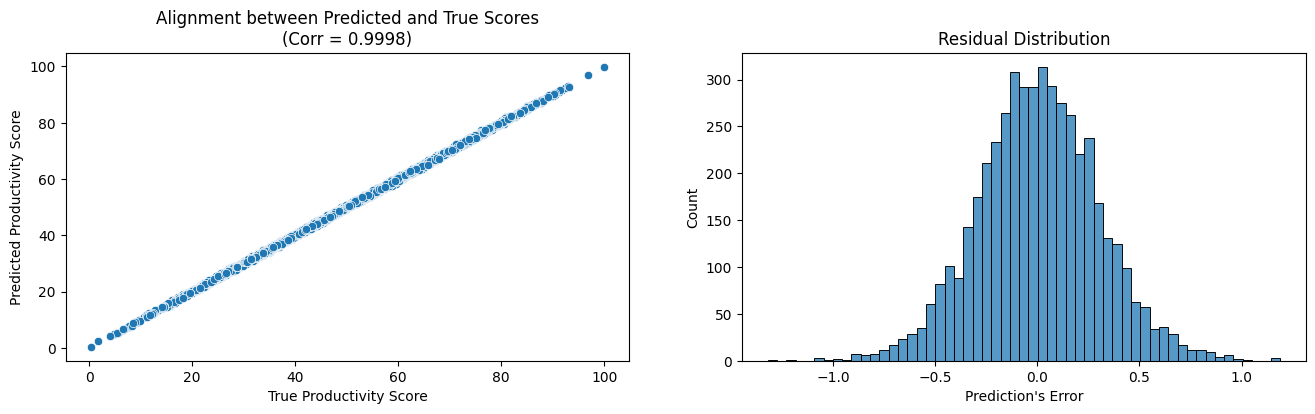

In [9]:
pearson_corr = np.corrcoef(y_val, model.predict(X_val))[0,1]

plt.figure(figsize=(16,4))
plt.subplot(121)
sea.scatterplot(x=y_val, y=model.predict(X_val))
plt.title(f"Alignment between Predicted and True Scores\n(Corr = {pearson_corr:.4f})")
plt.xlabel("True Productivity Score")
plt.ylabel("Predicted Productivity Score")

plt.subplot(122)
sea.histplot(x=model.predict(X_val)-y_val)
plt.title("Residual Distribution")
plt.xlabel("Prediction's Error")

plt.show()

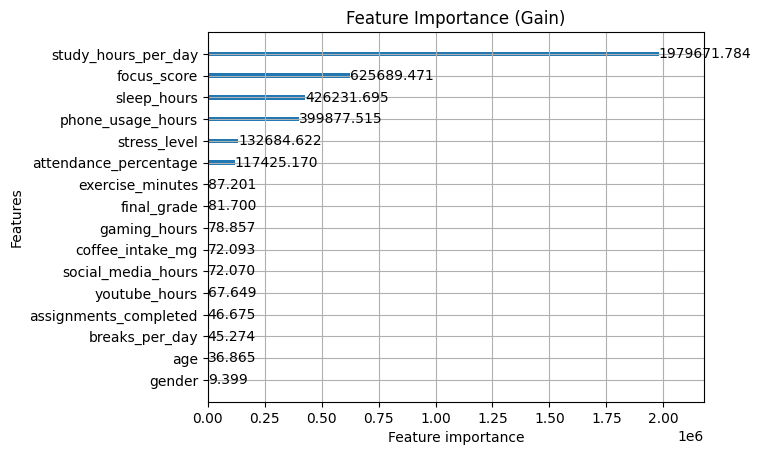

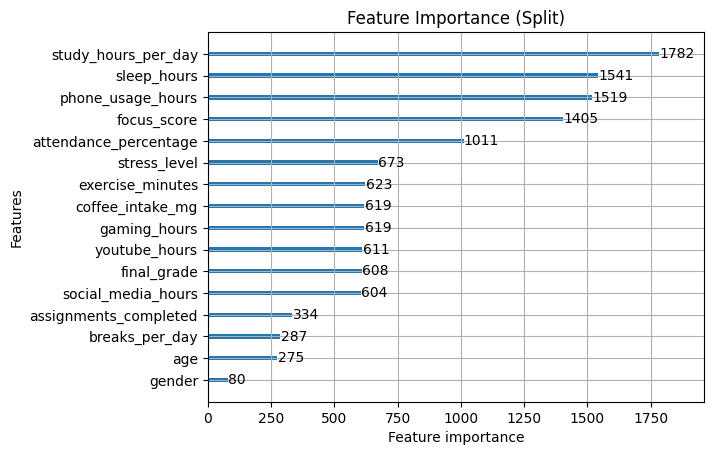

In [10]:
lightgbm.plot_importance(model, importance_type="gain", title="Feature Importance (Gain)")
lightgbm.plot_importance(model, importance_type="split", title="Feature Importance (Split)")

plt.show()

In [11]:
perm = permutation_importance(
    model, X_val, y_val,
    scoring="neg_root_mean_squared_error",
    n_repeats=20,
    random_state=3126,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature": X_val.columns,
    "permutation_importance": perm.importances_mean
}).sort_values("permutation_importance", ascending=False)

print(perm_df)

                  feature  permutation_importance
2     study_hours_per_day               16.554478
14            focus_score                8.972426
3             sleep_hours                7.407304
4       phone_usage_hours                7.318186
13           stress_level                4.114598
12  attendance_percentage                3.690598
11  assignments_completed                0.000532
7            gaming_hours                0.000187
1                  gender               -0.000033
6           youtube_hours               -0.000078
0                     age               -0.000159
9        coffee_intake_mg               -0.000646
15            final_grade               -0.000843
8          breaks_per_day               -0.001045
5      social_media_hours               -0.001274
10       exercise_minutes               -0.001283


In [12]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

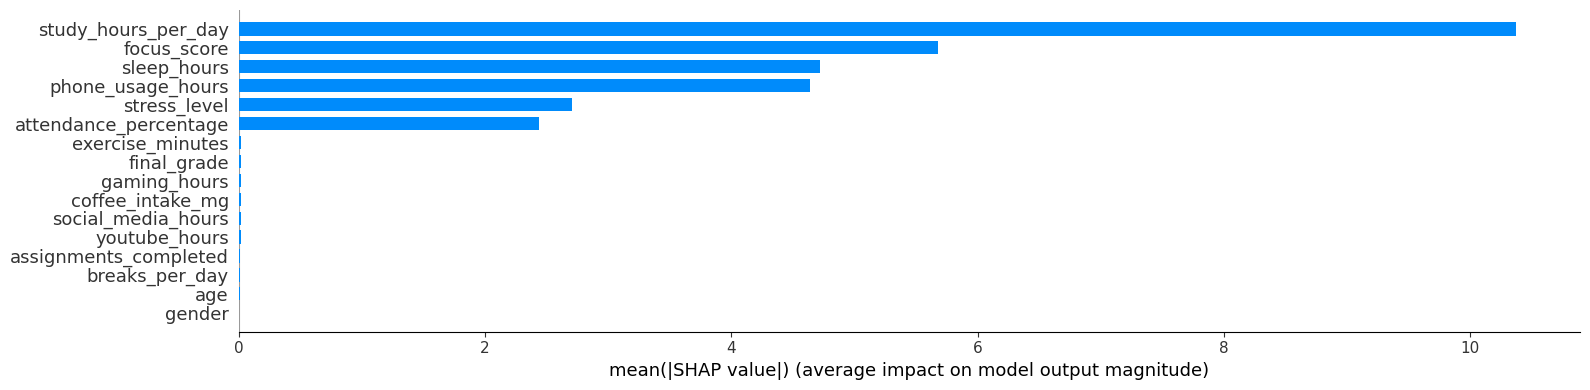

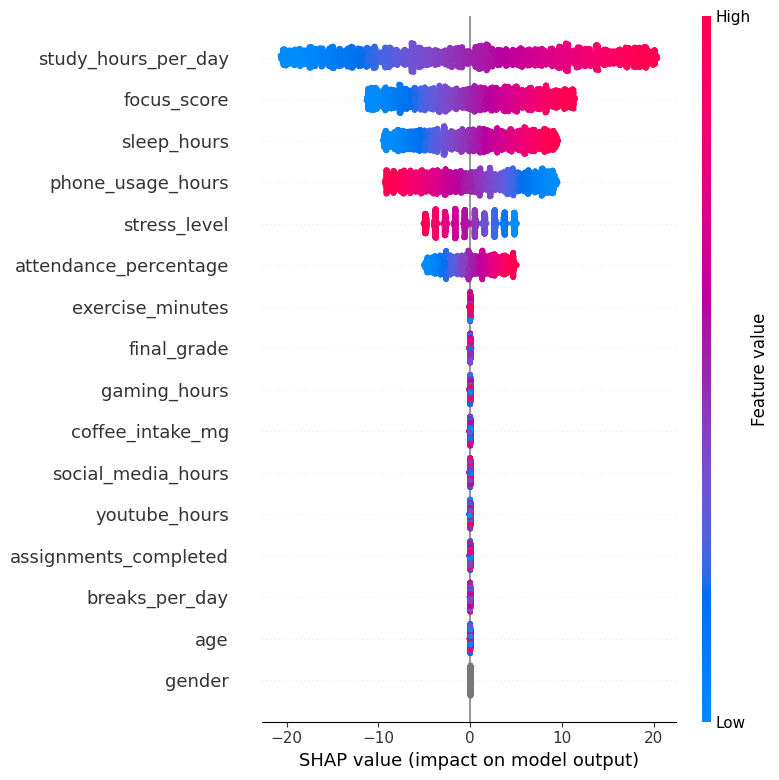

In [13]:
shap.summary_plot(shap_values, X_val, plot_type="bar", plot_size=(16,4))
shap.summary_plot(shap_values, X_val)

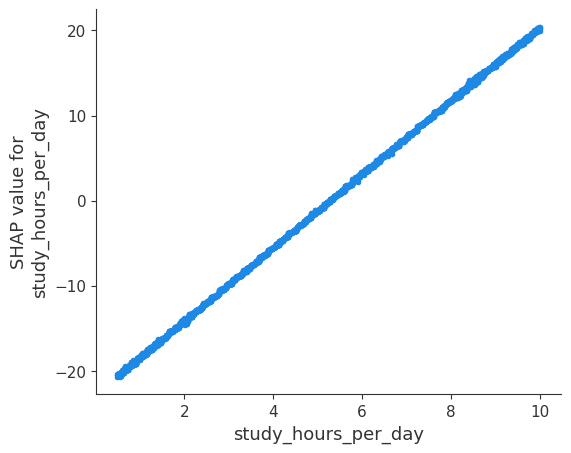

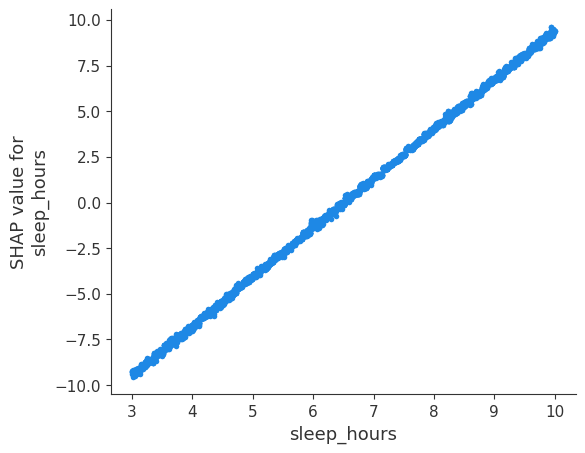

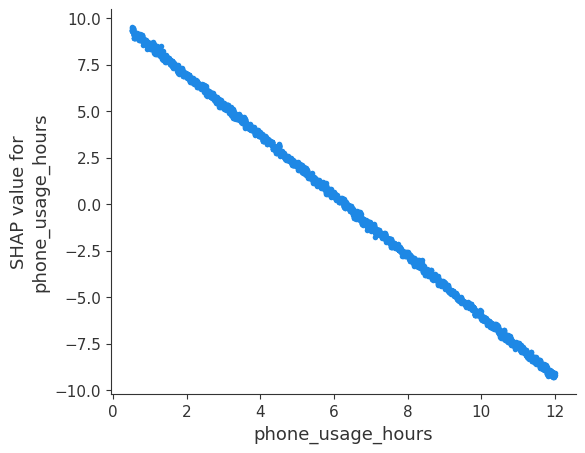

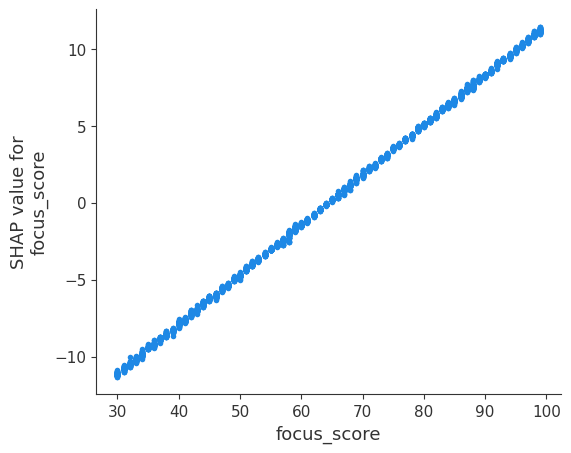

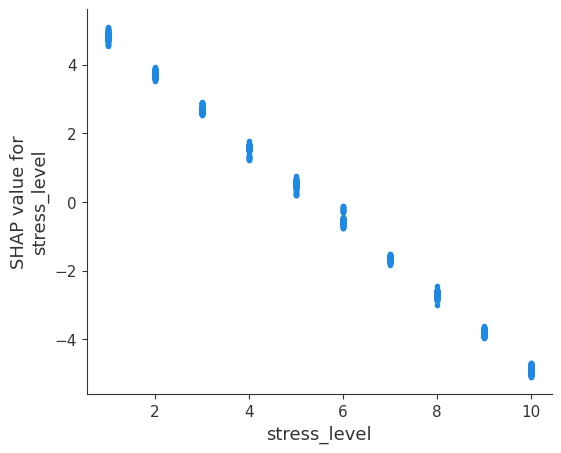

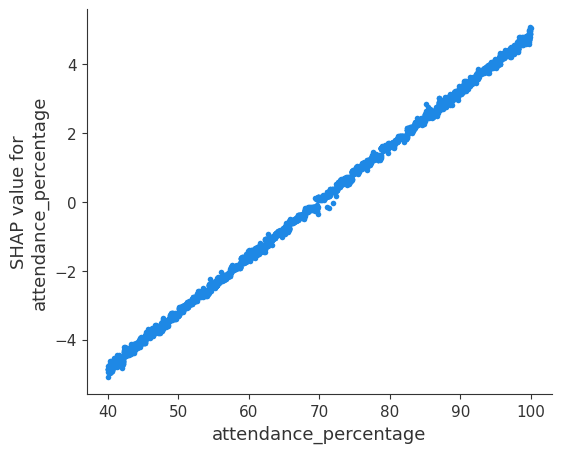

In [14]:
top_features = [
    "study_hours_per_day",
    "sleep_hours",
    "phone_usage_hours",
    "focus_score",
    "stress_level",
    "attendance_percentage"
]

for feature in top_features:
    shap.dependence_plot(
        feature,
        shap_values,
        X_val,
        interaction_index=None
    )

### In the end, it appears that these 6 features display the strongest predictive signals for the model to predict productivity scores, and they are suprisingly linear signals as well! 

# Submission

In [15]:
# 5 fold mean RMSE of 0.313
lgbm_params = {
    "objective": "regression",
    "metric":"rmse",
    'n_estimators': 4200,
    'max_depth': 4, 
    'min_child_samples': 27, 
    'learning_rate': 0.4519543556274892, 
    'subsample_freq': 7, 
    'colsample_bytree': 0.6394789787333435, 
    'reg_alpha': 2.8227813683691134, 
    'reg_lambda': 3.609134307913427, 
    'subsample': 0.8830822978218495, 
    'num_leaves': 4,
    'random_state':3126,
    'n_jobs':-1,
    'verbosity':-1
}

X["gender"]    = X["gender"].astype("category")
test["gender"] = test["gender"].astype("category")

model = LGBMRegressor(**lgbm_params)
model.fit(
    X, y,
    categorical_feature=["gender"]
)

LGBMRegressor(colsample_bytree=0.6394789787333435,
              learning_rate=0.4519543556274892, max_depth=4, metric='rmse',
              min_child_samples=27, n_estimators=4200, n_jobs=-1, num_leaves=4,
              objective='regression', random_state=3126,
              reg_alpha=2.8227813683691134, reg_lambda=3.609134307913427,
              subsample=0.8830822978218495, subsample_freq=7, verbosity=-1)

In [16]:
sample_submission["productivity_score"] = model.predict(test)
sample_submission.to_csv("submission.csv", index=False)

In [17]:
joblib.dump(lgbm_params, "lgbm_params.joblib")

['lgbm_params.joblib']